In [1]:
import random
from argparse import ArgumentParser
from decimal import Decimal
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd
import numpy as np
from preprocess_data import clean_data, create_balance_df, parse_and_assign_cex
from analyze_data import *
import os.path

pd.options.display.max_colwidth = 100
pd.options.display.width = 0  # Set width to 0 to auto-adjust based on the content
pd.options.display.max_columns = None  # Show all columns
pd.options.display.expand_frame_repr = False  # Disable wrapping to new line

Load data files

In [2]:
file_balances_uni = "../data/uniswap.csv"
file_original_uni = "../data/outputUniswap_fromBlock_10861674_toBlock_19955500.csv"
timelock_address_uni = "0x1a9c8182c09f50c8318d769245bea52c32be35bc"

In [3]:
file_balances_mkr = "../data/mkr.csv"
file_original_mkr = "../data/outputMKR_fromBlock_4620855_toBlock_10620857.csv"

Initialize data frames

In [4]:
df_uni = pd.read_csv(file_balances_uni)
df_uni["balance"] = df_uni["balance"].apply(Decimal)
df_uni["amount_in"] = df_uni["amount_in"].apply(Decimal)
df_uni["amount_out"] = df_uni["amount_out"].apply(Decimal)

/tmp/ipykernel_18260/2278918116.py:1: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_uni = pd.read_csv(file_balances_uni)


In [5]:
df_mkr = pd.read_csv(file_balances_mkr)
df_mkr["balance"] = df_mkr["balance"].apply(Decimal)
df_mkr["amount_in"] = df_mkr["amount_in"].apply(Decimal)
df_mkr["amount_out"] = df_mkr["amount_out"].apply(Decimal)

In [6]:
df_mkr

,Unnamed: 0,address,amount_in,transfer_frequency_in,amount_out,transfer_frequency_out,balance,cex
0,0,0x0000000000000000000000000000000000000000,726890450928383,4.999999e-07,0,0.000000e+00,726890450928383,NaN
1,1,0x0000000000000000000000000000000000000ad3,31146524766249368,1.666666e-07,0,0.000000e+00,31146524766249368,NaN
2,2,0x000000000000000000000000000000000000dead,154552448578266,3.333333e-07,0,0.000000e+00,154552448578266,NaN
3,3,0x000000000000006f6502b7f2bbac8c30a3f67e9a,1479591057066895116032,1.866666e-05,1479591057066895116032,1.866666e-05,0,NaN
4,4,0x000000000000541e251335090ac5b47176af4f7e,638384827849069008933,1.260000e-04,635883547528967032060,9.699998e-05,2501280320101976576,NaN
...,...,...,...,...,...,...,...,...
75990,75990,0xfffe9361d8371c4c74374a2fe862b24e964d986c,3673333333333333504,1.666666e-07,50170164211586,1.666666e-07,3673283163169121792,NaN
75991,75991,0xffff2c1d5fa3f7dc16902c3f4dfc56b138474d3e,8979000000000000000,1.666666e-07,8979000000000000000,1.666666e-07,0,NaN
75992,75992,0xffff46e05a09314daae9176fc32dba0f4172dcdb,1,1.666666e-07,1,1.666666e-07,0,NaN
75993,75993,0xffff4cd43a40d0a0540783e0f988d147ef460595,52874890539557729.0,1.333333e-06,52874890539557729.0,1.333333e-06,0,NaN


Preprocess data

In [7]:
df_uni_non_negative = clean_data(df_uni)    # remove negative balances and sort descending
df_uni_only_positive = remove_zero_balances(df_uni_non_negative)    # remove zero balances
df_uni_only_positive_removed_timelockAddress = remove_address(df_uni_only_positive, timelock_address_uni)

print("Number of addresses that hold tokens: \n", df_uni_only_positive_removed_timelockAddress.shape[0])

Number of addresses that hold tokens: 
 382522


In [8]:
df_mkr_non_negative = clean_data(df_mkr)    # remove negative balances and sort descending
df_mkr_only_positive = remove_zero_balances(df_mkr_non_negative) # remove zero balances

print("Number of addresses that hold tokens: \n", df_mkr_only_positive.shape[0])

Number of addresses that hold tokens: 
 27858


## Metrics

In [9]:
df_uni_only_positive_removed_timelockAddress.head(10)

,Unnamed: 0,address,amount_in,transfer_frequency_in,amount_out,transfer_frequency_out,balance,cex
370039,370039,0x47173b170c64d16393a52e6c480b3ad8c302ba1e,39761682693918000000000000,2.199295e-07,16714202180719478000000000,5.498236e-07,23047480513198522000000000,NaN
318385,318385,0x3d30b1ab88d487b0f3061f40de76845bec3f1e94,43000000000000000000000000,1.099647e-07,26223928240740740740740738,6.597884e-07,16776071759259259259259262,NaN
649014,649014,0x7d2d43e63666f45b40316b44212325625dbaeb40,15759557158154400000000000,4.398589e-07,2504870339500000000000000,1.099647e-06,13254686818654400000000000,NaN
48214,48214,0x090d4613473dee047c3f2706764f49e0821d256e,150002600459653843000000000,1.539506e-06,136965580688674000000000000,2.429143e-02,13037019770979843000000000,NaN
78010,78010,0x0ec9e8aa56e0425b60dee347c8efbad959579d0f,30000000076569300000000000,2.199295e-07,17388668720908390000000000,1.539506e-06,12611331355660910000000000,NaN
1290796,1290796,0xf977814e90da44bfa03b6295a0616a897441acec,81716912931976964981621181,8.247355e-06,69208316922976964981621181,4.398589e-06,12508596009000000000000000,binance
564338,564338,0x6cc5f688a315f3dc28a7781717a9a798a59fda7b,100354081826020357678147603,3.404508e-03,88846188151855080000000000,2.807070e-03,11507893674165277678147603,okex
469356,469356,0x5a52e96bacdabb82fd05763e25335261b270efcb,26666973000000000000000000,3.298942e-07,15866973000000000000000000,1.649471e-06,10800000000000000000000000,binance
702543,702543,0x878f0822a9e77c1dd7883e543747147be8d63c3b,24700000000000000000000000,1.099647e-07,13936624086003920000000000,1.319577e-06,10763375913996080000000000,NaN
853382,853382,0xa4c9492d5f1578911756a4f8463b45482deae37a,21880414703401289000000000,1.088651e-05,12570489829000000000000000,7.037743e-06,9309924874401289000000000,NaN


In [10]:
df_mkr_only_positive.head(10)


,Unnamed: 0,address,amount_in,transfer_frequency_in,amount_out,transfer_frequency_out,balance,cex
47529,47529,0x9ef05f7f6deb616fd37ac3c959a2ddd25a54e4f5,767909231532951190879667.0,2.286666e-04,489480886030293008294343,1.415000e-04,278428345502658168094720,NaN
42738,42738,0x8ee7d9235e01e6b42345120b5d270bdb763624c7,271772229894197754200064,1.666666e-07,168216041999999996919808,6.166666e-06,103556187894197753217024,NaN
2019,2019,0x05e793ce0c6027323ac150f6d45c2344d28b6019,70999999999999998164992,6.666666e-07,21000000000000000000000,6.666666e-07,49999999999999995805696,NaN
74923,74923,0xfc7e22c6afa3ebb723bdde26d6ab3783aab9726b,51291499999999997378560,1.166666e-06,19786849999999999868928,1.983333e-05,31504649999999999934464,NaN
29984,29984,0x642ae78fafbb8032da552d619ad43f1d81e4dd7c,2009575676357558627260974.0,2.500000e-05,1979387832748474746521204.0,3.731666e-04,30187843609083879882752,NaN
45545,45545,0x9866772a9bdb4dc9d2c5a4753e8658b8b0ca1fc3,41029783213208053604963,2.883333e-04,14763631810031905946809,2.003333e-04,26266151403176146763776,NaN
72235,72235,0xf37216a8ac034d08b4663108d7532dfcb44583ed,21554930000000000851968,3.333333e-07,0,0.000000e+00,21554930000000001769472,NaN
67,67,0x000be27f560fef0253cac4da8411611184356549,120223999999999998427136,2.333333e-06,99478850000000001048576,3.499999e-06,20745149999999998754816,NaN
25131,25131,0x53bbf7e3c650c3d4a4e8d7c981cc72ce1206e932,17999999999999999931392,6.999999e-06,0,0.000000e+00,18000000000000000000000,NaN
66652,66652,0xe034d760efed8303ff80a622d65ab17d65e2d460,15619943357194302390272,1.666666e-07,0,0.000000e+00,15619943357194302390272,NaN


In [11]:
# uni - some statistics

print_top_percentages(df_uni_only_positive_removed_timelockAddress)
print_top_traders(df_uni_only_positive_removed_timelockAddress)
print_transfer_frequency(file_original_uni)
print_cex_percentages(df_uni_only_positive_removed_timelockAddress)

Top 10 percentage: 21.70%
Top 100 percentage: 73.94%
Top 1000 percentage: 95.61%

Top senders: 
                                            address                      balance          cex
340204   0x41653c7d61609d856f29355e404f310ec4142cfb             2758162612694493          NaN
153078   0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801  2389244318714231259971746.0          NaN
1095711  0xd3d2e2692501a5c9ca623199d38826e513033a17   296150534151073172965800.0          NaN
745201   0x8fdb3816fe10e16aaa9b12b3c4688c873efe2eca                 224000000000          NaN
447613   0x56178a0d5f301baf6cf3e1cd53d9863437345bf9                         2287          NaN
212842   0x28c6c06298d514db089934071355e5743bf21d60    1156776254099902652161204      binance
879423   0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43     165454997447195443369833  coinbasepro
279335   0x35a18000230da775cac24873d00ff85bccded550  1710109454349553903820275.0          NaN
48214    0x090d4613473dee047c3f2706764f49e0821d256e   1303

In [35]:
df_uni_cex_not_None = df_uni_only_positive_removed_timelockAddress[~pd.isnull(df_uni_only_positive_removed_timelockAddress["cex"])]
df_uni_cex_is_None = df_uni_only_positive_removed_timelockAddress[pd.isnull(df_uni_only_positive_removed_timelockAddress["cex"])]

print("Number of cex addresses: ", df_uni_cex_not_None.shape[0])
print("Number of other addresses: ", df_uni_cex_is_None.shape[0])

Number of cex addresses:  43
Number of other addresses:  382479


In [12]:
# mkr - some statistics

print_top_percentages(df_mkr_only_positive)
print_top_traders(df_mkr_only_positive)
print_transfer_frequency(file_original_mkr)
print_cex_percentages(df_mkr_only_positive)

Top 10 percentage: 58.42%
Top 100 percentage: 87.61%
Top 1000 percentage: 97.77%

Top senders: 
                                          address                   balance  cex
29984  0x642ae78fafbb8032da552d619ad43f1d81e4dd7c   30187843609083879882752  NaN
42538  0x8e2a84d6ade1e7fffee039a35ef5f19f13057152    1807613168429906526208  NaN
47529  0x9ef05f7f6deb616fd37ac3c959a2ddd25a54e4f5  278428345502658168094720  NaN
37011  0x7bb0b08587b8a6b8945e09f1baca426558b0f06a                   6682139  NaN
63127  0xd48d3462c5e5a5d568c8f8ec3366241ed8b46bd1            24765366630400  NaN
17290  0x39755357759ce0d7f32dc8dc45414cca409ae24e      30049961083067633664  NaN
13489  0x2c4bd064b998838076fa341a83d007fc2fa50957    1742712011239054114816  NaN
6437   0x14fbca95be7e99c15cc2996c6c9d841e54b79425        100000000000581728  NaN
42075  0x8cc70d4a9fa194a5b4191aa415a81bd8f8bbe2f1          4275642106314192  NaN
42738  0x8ee7d9235e01e6b42345120b5d270bdb763624c7  103556187894197753217024  NaN

Top receiver

In [36]:
df_mkr_cex_not_None = df_mkr_only_positive[~pd.isnull(df_mkr_only_positive["cex"])]
df_mkr_cex_is_None = df_mkr_only_positive[pd.isnull(df_mkr_only_positive["cex"])]

print("Number of cex addresses: ", df_mkr_cex_not_None.shape[0])
print("Number of other addresses: ", df_mkr_cex_is_None.shape[0])

Number of cex addresses:  19
Number of other addresses:  27839


### Gini index

In [7]:
gini_index_uni = compute_gini_index(df_uni_only_positive_removed_timelockAddress)
print("gini index: ", gini_index_uni)

gini index:  0.9952059161147626132523910141


In [13]:
gini_index_mkr = compute_gini_index(df_mkr_only_positive)
print("gini index: ", gini_index_mkr)

gini index:  0.9918696513550150109823404546


### Herfindahl hirschman index:

In [9]:
hhi = compute_herfindahl_hirschman_index(df_uni_only_positive_removed_timelockAddress)
print("hhi: ", hhi)

# limited to the top 50 token holder
hhi = compute_herfindahl_hirschman_index(df_uni_only_positive_removed_timelockAddress, top_n_player=10)
print("hhi: ", hhi)

hhi = compute_herfindahl_hirschman_index(df_uni_only_positive_removed_timelockAddress, top_n_player=2)
print("hhi: ", hhi)

hhi:  0.009764410451879474
hhi_normalized:  0.009761821742790174
hhi:  0.009761821742790174
hhi:  0.005078896279045029
hhi_normalized:  0.005076295320917969
hhi:  0.005076295320917969
hhi:  0.0021435903362048586
hhi_normalized:  0.0021409817044966283
hhi:  0.0021409817044966283


In [10]:
hhi = compute_herfindahl_hirschman_index(df_mkr_only_positive)
print("hhi: ", hhi)

# limited to the top 50 token holder
hhi = compute_herfindahl_hirschman_index(df_mkr_only_positive, top_n_player=10)
print("hhi: ", hhi)

hhi = compute_herfindahl_hirschman_index(df_mkr_only_positive, top_n_player=2)
print("hhi: ", hhi)

hhi:  0.09281499608825805
hhi:  0.0910979452132751
hhi:  0.08479498760425472


## Charts

### Timeline
Gini index in timeline:

#### Uni Token:

In [11]:
block_step_size = 100_000

In [24]:
uni_timeline_file = "../data/uni_timeline_step_size_" + str(block_step_size) + ".csv"

if os.path.isfile(uni_timeline_file):
    # file already exists
    uni_timeline = pd.read_csv(uni_timeline_file)
    
else:
    uni_timeline = create_and_export_timeline(file_original_uni, block_step_size, uni_timeline_file, addresses_to_remove=["0x1a9c8182c09f50c8318d769245bea52c32be35bc"])

uni_timeline

,Unnamed: 0,block_number,gini_index,tx_per_block
0,0,10961674,0.989849,7.239988
1,1,11061674,0.991963,1.655890
2,2,11161674,0.993115,1.309740
3,3,11261674,0.993525,1.263110
4,4,11361674,0.994157,1.105370
...,...,...,...,...
85,85,19461674,0.995198,0.324090
86,86,19561674,0.995217,0.211470
87,87,19661674,0.995226,0.304600
88,88,19761674,0.995180,0.222080


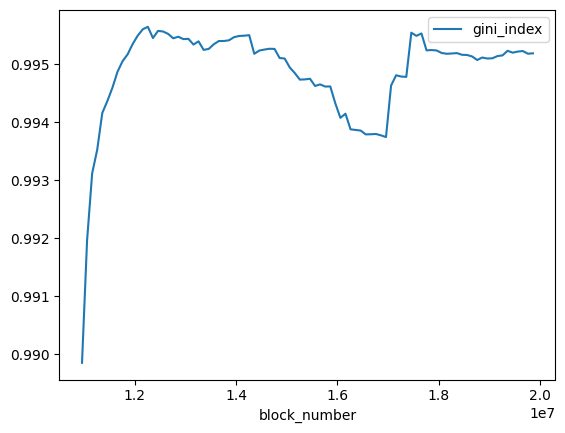

In [25]:
create_timeline_plot(uni_timeline, 'gini_index')

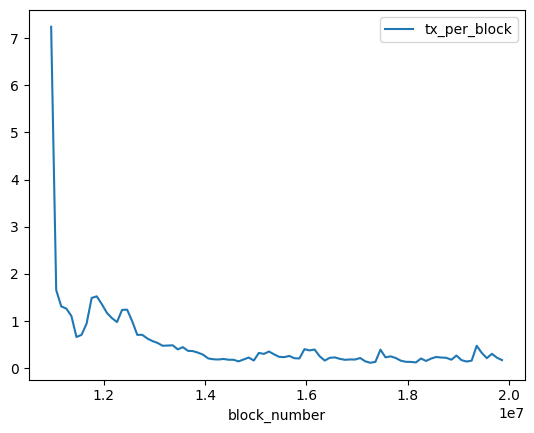

In [26]:
create_timeline_plot(uni_timeline, 'tx_per_block')

In [27]:
create_timeline_plot(uni_timeline, 'hhi')

KeyError: 'hhi'

#### Mkr Token:

In [19]:
mkr_timeline_file = "../data/mkr_timeline_step_size_" + str(block_step_size) + ".csv"

if os.path.isfile(mkr_timeline_file):
    # file already exists
    mkr_timeline = pd.read_csv(mkr_timeline_file)
    
else:
    mkr_timeline = create_and_export_timeline(file_original_mkr, block_step_size, mkr_timeline_file)

mkr_timeline

,Unnamed: 0,block_number,gini_index,tx_per_block,hhi
0,0,4720855,0.899268,0.00029,0.994502
1,1,4820855,0.985617,0.02303,0.262063
2,2,4920855,0.987931,0.01817,0.257768
3,3,5020855,0.988059,0.02598,0.245869
4,4,5120855,0.988369,0.02571,0.244043
5,5,5220855,0.988220,0.02318,0.237715
6,6,5320855,0.988344,0.03275,0.228777
7,7,5420855,0.988402,0.03626,0.219231
8,8,5520855,0.988747,0.05323,0.217762
9,9,5620855,0.988915,0.05525,0.215958


In [21]:
print(type(mkr_timeline.iloc[0]["hhi"]))
print(type(mkr_timeline.iloc[0]["gini_index"]))

<class 'numpy.float64'>
<class 'numpy.float64'>


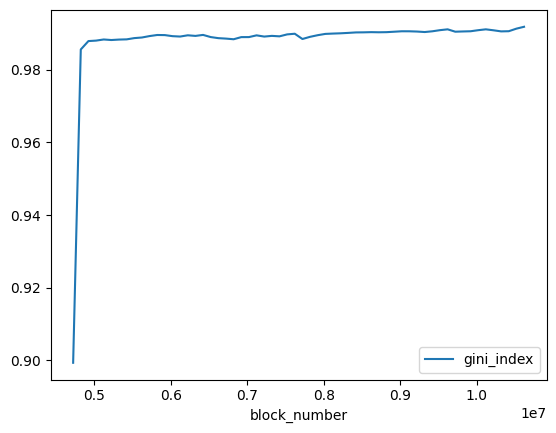

In [20]:
create_timeline_plot(mkr_timeline, 'gini_index')

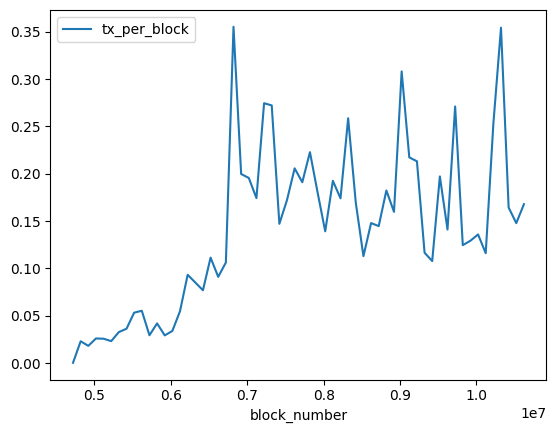

In [22]:
create_timeline_plot(mkr_timeline, 'tx_per_block')


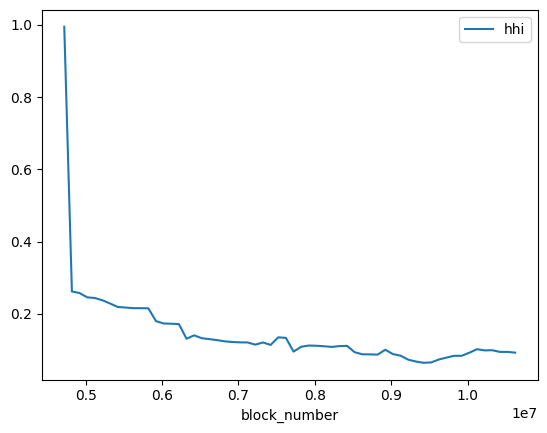

In [29]:
create_timeline_plot(mkr_timeline, 'hhi')

In [12]:
# TODO: Show tx frequency for all transfers (+ maybe: for top traders or cex's)

### Pie Chart
Balances distribution pie chart:

#### Uni Token:

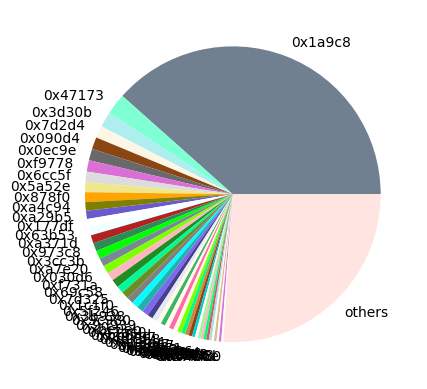

In [13]:
# all addresses with positive balance
create_pie_chart(
    merge_others_at_cut_off_value(df_uni_only_positive, 50), 
    "../data/uniswap_pie_chart.png")

The timelock address holds a huge amount of the tokens.

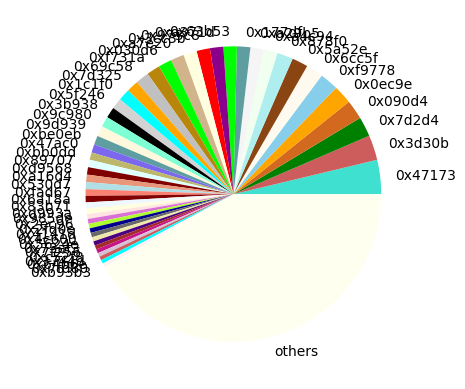

In [14]:
# all addresses with positive balance, except the timelock address
create_pie_chart(
    merge_others_at_cut_off_value(df_uni_only_positive_removed_timelockAddress, 50), 
    "../data/uniswap_pie_chart.png")

        cex                     balance
1   binance  36697432554638172652161204
18     okex  11521347873058447678147604
14   kraken   2111022000000000000000000
5     bybit   2001647090445974192469061
9   gate-io    532236875036369327648747


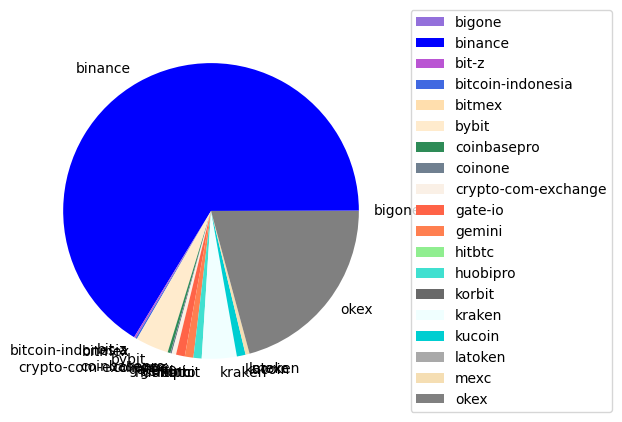

In [10]:
df_uni_cex = aggregate_cex_balances(df_uni_only_positive_removed_timelockAddress)
print(df_uni_cex.sort_values("balance", ascending=False).head(5))

create_pie_chart(df_uni_cex, '../data/uniswap_pie_chart_cex.png', labels=df_uni_cex['cex'], show_legend=True)

In [17]:
# TODO make pie chart also including None exchanges

#### Mkr Token:

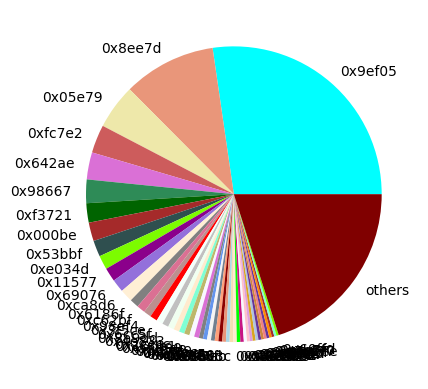

In [30]:
# all addresses with positive balance
create_pie_chart(
    merge_others_at_cut_off_value(df_mkr_only_positive, 50), 
    "../data/uniswap_pie_chart.png")

                    cex                 balance
1               binance  8237137216341507309568
11                 okex  7244545361574444625905
8                kraken  4071830276279999922176
9                kucoin  2688480437226438131712
3   crypto-com-exchange  1480594015603943407616


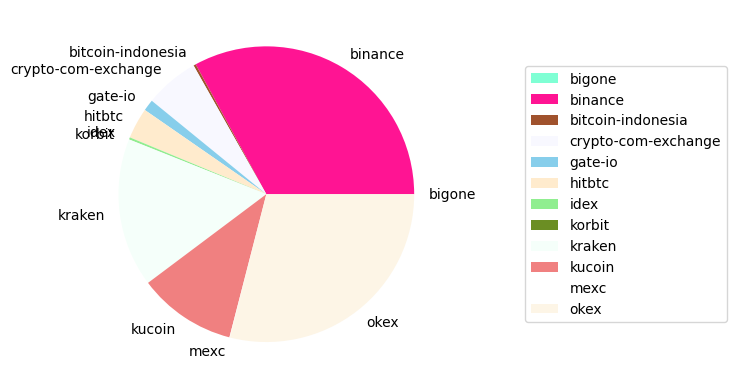

In [9]:
df_mkr_cex = aggregate_cex_balances(df_mkr_only_positive)
print(df_mkr_cex.sort_values("balance", ascending=False).head(5))

create_pie_chart(df_mkr_cex, '../data/uniswap_pie_chart_cex.png', labels=df_mkr_cex['cex'], show_legend=True)